In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kaggle

In [ ]:
!kaggle datasets download -d landlord/handwriting-recognition

Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0
 99% 1.24G/1.26G [00:11<00:00, 119MB/s]
100% 1.26G/1.26G [00:11<00:00, 119MB/s]


In [ ]:
%%capture
!unzip handwriting-recognition.zip -d dataset

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers

In [ ]:
train_path = r'/content/dataset/train_v2/train'
valid_path = r'/content/dataset/validation_v2/validation'

In [ ]:
df_train = pd.read_csv(r'/content/dataset/written_name_train_v2.csv')
df_valid = pd.read_csv(r'/content/dataset/written_name_validation_v2.csv')
# df_valid.drop(['GENERIC_NAME'], inplace = True, axis = 1)
# df_train.drop(['GENERIC_NAME'], inplace = True, axis = 1)
df_train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
df_train.dropna(inplace=True)
df_valid.dropna(inplace=True)

In [ ]:
vocab = set()
max_len = 0

for label in list(df_train['IDENTITY']):
    label = label.split(" ")[-1].strip()
    for char in label:
        vocab.add(char)
    max_len = max(len(label), max_len)

char_to_num = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

train_labels = clean_labels(df_train['IDENTITY'])
valid_labels = clean_labels(df_valid['IDENTITY'])

In [ ]:
def prepare_dataset_train(img_path, label):
  img_path = tf.strings.join([train_path, img_path], separator = os.path.sep)
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img, channels=1)
  img = tf.image.resize(img, (256, 64))
  img = tf.cast(img, tf.float32) / 255.0

  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  label_len = tf.shape(label)[0]
  pad_amount = max_len - label_len
  label = tf.pad(label, paddings = [[0, pad_amount]], constant_values = 99)
  return {'image': img, 'label': label}

def prepare_dataset_val(img_path, label):
  img_path = tf.strings.join([valid_path, img_path], separator = os.path.sep)
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img, channels=1)
  img = tf.image.resize(img, (256, 64))
  img = tf.cast(img, tf.float32) / 255.0

  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  label_len = tf.shape(label)[0]
  pad_amount = max_len - label_len
  label = tf.pad(label, paddings = [[0, pad_amount]], constant_values = 99)
  return {'image': img, 'label': label}

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((df_train['FILENAME'], train_labels))
val_ds= tf.data.Dataset.from_tensor_slices((df_valid['FILENAME'], valid_labels))

train_ds = (
    train_ds.map(prepare_dataset_train, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    .batch(32)
)
val_ds = (
    val_ds.map(prepare_dataset_val, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
    .batch(32)
)

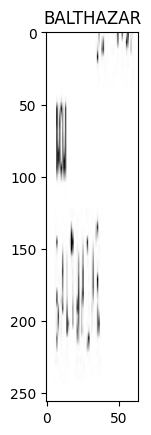

In [ ]:
for data  in train_ds.take(1):
    img = data['image']
    label = data['label']
    img = img[0, :]
    label = label[0, :]
    label = tf.gather(label, tf.where(tf.math.not_equal(label, 99)))
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    plt.imshow(img, cmap = 'grey')
    plt.title(label)

In [ ]:
def build_localization_network(inp_shape):
    input = layers.Input(shape = inp_shape)

    x = layers.Conv2D(32, kernel_size = 7, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(input)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, kernel_size = 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)

    x = layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.Dropout(0.4)(x)

    theta = layers.Dense(3 * 2, activation=None,
                         kernel_initializer=tf.keras.initializers.Zeros(),
                         bias_initializer=tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0]))(x)

    return tf.keras.Model(input, theta, name = 'LocalizationNetwork')

class spatialTransformer(tf.keras.layers.Layer):
    def __init__(self, output_size):
        super(spatialTransformer, self).__init__()
        self.output_size = output_size

    def call(self, inputs):
        image, theta = inputs
        batch_size = tf.shape(image)[0]
        h, w = self.output_size

        grid = self._generate_grid(batch_size, h, w)
        theta = tf.cast(theta, dtype = tf.float32)
        grid = tf.cast(grid, dtype = tf.float32)

        theta = tf.reshape(theta, [-1, 2, 3])
        transformed_grid = tf.matmul(theta, grid)
        transformed_grid = tf.reshape(transformed_grid, [batch_size, h, w, 2])

        x = (transformed_grid[..., 0] + 1) * (tf.cast(tf.shape(image)[2], tf.float32) - 1) / 2
        y = (transformed_grid[..., 1] + 1) * (tf.cast(tf.shape(image)[1], tf.float32) - 1) / 2

        output = self._bilinear_sampler(image, x, y)
        return output

    def _generate_grid(self, batch_size, h, w):
        x = tf.linspace(-1.0, 1.0, w)
        y = tf.linspace(-1.0, 1.0, h)
        x_t, y_t = tf.meshgrid(x, y)
        x_t_flat = tf.reshape(x_t, [-1])
        y_t_flat = tf.reshape(y_t, [-1])
        ones = tf.ones_like(x_t_flat)
        sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])
        sampling_grid = tf.expand_dims(sampling_grid, axis=0)
        sampling_grid = tf.tile(sampling_grid, tf.stack([batch_size, 1, 1]))
        return sampling_grid

    def _bilinear_sampler(self, image, x, y):
        batch_size = tf.shape(image)[0]
        h = tf.shape(image)[1]
        w = tf.shape(image)[2]

        x = tf.clip_by_value(x, 0.0, tf.cast(w - 1, tf.float32))
        y = tf.clip_by_value(y, 0.0, tf.cast(h - 1, tf.float32))

        x0 = tf.cast(tf.floor(x), tf.int32)
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), tf.int32)
        y1 = y0 + 1

        x0 = tf.clip_by_value(x0, 0, w - 1)
        x1 = tf.clip_by_value(x1, 0, w - 1)
        y0 = tf.clip_by_value(y0, 0, h - 1)
        y1 = tf.clip_by_value(y1, 0, h - 1)

        Ia = self._gather_pixel(image, x0, y0)
        Ib = self._gather_pixel(image, x0, y1)
        Ic = self._gather_pixel(image, x1, y0)
        Id = self._gather_pixel(image, x1, y1)

        wa = (tf.cast(x1, tf.float32) - x) * (tf.cast(y1, tf.float32) - y)
        wb = (tf.cast(x1, tf.float32) - x) * (y - tf.cast(y0, tf.float32))
        wc = (x - tf.cast(x0, tf.float32)) * (tf.cast(y1, tf.float32) - y)
        wd = (x - tf.cast(x0, tf.float32)) * (y - tf.cast(y0, tf.float32))

        wa = tf.expand_dims(wa, axis=-1)
        wb = tf.expand_dims(wb, axis=-1)
        wc = tf.expand_dims(wc, axis=-1)
        wd = tf.expand_dims(wd, axis=-1)

        out = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id])
        return out

    def _gather_pixel(self, image, x, y):
        batch_size, height, width = tf.shape(image)[0], tf.shape(image)[1], tf.shape(image)[2]
        channels = tf.shape(image)[3]

        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1, 1))
        b = tf.tile(batch_idx, (1, height, width, 1))

        x = tf.expand_dims(x, axis=-1)
        y = tf.expand_dims(y, axis=-1)
        indices = tf.concat([b, y, x], axis=-1)

        return tf.gather_nd(image, indices)

def build_STN(input_shape, output_shape):
    inp = layers.Input(shape = input_shape)

    localization_net = build_localization_network(input_shape)
    theta = localization_net(inp)

    st_layer = spatialTransformer(output_shape)
    transformed_mat = st_layer([inp, theta])

    return tf.keras.Model(inp, transformed_mat, name = 'STN')

In [ ]:
inp_shape = (256, 64, 1)
out_shape = (256, 64)
stn_model = build_STN(inp_shape, out_shape)

In [ ]:
class ctcLayer(tf.keras.layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = tf.keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred

In [ ]:
def nw_model(img_w, img_h):
  input_img = tf.keras.Input(shape=(img_w, img_h, 1), name="image")
  labels = tf.keras.layers.Input(name="label", shape=(None,))

  augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomCrop(height=int(img_w * 0.9), width=int(img_h * 0.9)),
        tf.keras.layers.Resizing(img_w, img_h),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
    ], name="augmentation")

  x = augmentation(input_img)

  x = stn_model(x)

  x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
  x = tf.keras.layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv2",
  )(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

  new_shape = ((img_w // 4), (img_h // 4) * 64)
  x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
  )(x)
  x = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
  )(x)

  x = tf.keras.layers.Dense(
      len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)

  output = ctcLayer(name="ctc_loss")(labels, x)

  model = tf.keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognition"
  )

  model.compile(optimizer=tf.keras.optimizers.Adam())
  return model

In [ ]:
model = nw_model(256, 64)
model.summary()

Model: "handwriting_recognition"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 256, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ augmentation (Sequential) │ (None, 256, 64, 1)     │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ STN (Functional)          │ (None, 256, 64, 1)     │      8,442,374 │ augmentation[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 256, 64, 32)    │            320 │ STN[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 128, 32, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 128, 32, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 64, 16, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 1024)       │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 64, 64)         │         65,600 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64, 256)        │        197,632 │ dropout_3[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 64, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 64, 52)         │          6,708 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (ctcLayer)       │ (None, 64, 52)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,895,482 (33.93 MB)

 Trainable params: 8,895,482 (33.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
his = model.fit(train_ds, epochs = 150, validation_data = val_ds, callbacks = [tf.keras.callbacks.EarlyStopping(patience = 20)])

Epoch 1/150
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 1428s 137ms/step - loss: 647.4472 - val_loss: 600.7310
Epoch 2/150
  997/10325 ━━━━━━━━━━━━━━━━━━━━ 19:33 126ms/step - loss: 600.0247

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.ops.nn.ctc_decode(pred, sequence_lengths=input_len)[0][0][
        :, :max_len
    ]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = (
            tf.strings.reduce_join(num_to_char(res))
            .numpy()
            .decode("utf-8")
            .replace("[UNK]", "")
        )
        output_text.append(res)
    return output_text

In [ ]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").output, model.get_layer(name="dense2").output
)

In [ ]:
def process_img(img_path):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.resize(img, (256, 64))
  img = tf.cast(img, tf.float32) / 255.0
  img = tf.expand_dims(img, axis=0)
  return img

In [ ]:
img = process_img(r'/content/dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words/1.png')

In [ ]:
preds = prediction_model.predict(img)
pred_texts = decode_batch_predictions(preds)

In [ ]:
print(pred_texts)

In [ ]:
prediction_model.save('model_stn_ocr_1000_epochs.keras')